In [1]:
import os
import json
import joblib
import multiprocessing as mp
import time
import itertools


import pandas as pd
from dotenv import load_dotenv
from serpapi import GoogleSearch
import tiktoken
from openai import OpenAI
from tqdm import tqdm
load_dotenv()

from sheet import *


ORGANIZATION_ID = 'org-yhi37KGOruXgo9Zm5vj4VSFa'
serp_api_key = '9d4e074bca8f9f7fa9ca5e05b874ea7da4f07cb505292ab29a0e1b91ffa0340a'
base = "https://serpapi.com/search.json" 
engine = 'google'
# query = "Coffee"
google_domain = 'google.com.tw'
gl = 'tw'
lr = 'lang_zh-TW'
# url = f"{base}?engine={engine}&q={query}&google_domain={google_domain}&gl={gl}&lr={lr}"

client = OpenAI( organization = ORGANIZATION_ID)

category2supercategory = {
        "小吃店": "中式",
        "日式料理(含居酒屋，串燒)": "中式",
        "火(鍋／爐)": "中式",
        "東南亞料理(不含日韓)": "中式",
        "海鮮熱炒": "中式",
        "特色餐廳(含雞、鵝、牛、羊肉)": "中式",
        "傳統餐廳": "中式",
        "燒烤": "中式", 
        "韓式料理(含火鍋，烤肉)": "中式",
        "西餐廳(含美式，義式，墨式)": "西式"
    }

supercategory2category = {
        "中式": [
            "小吃店",
            "日式料理(含居酒屋，串燒)",
            "火(鍋／爐)",
            "東南亞料理(不含日韓)",
            "海鮮熱炒",
            "特色餐廳(含雞、鵝、牛、羊肉)",
            "傳統餐廳",
            "燒烤", 
            "韓式料理(含火鍋，烤肉)"
        ],
        "西式": ["西餐廳(含美式，義式，墨式)"]
    }

n_processes =4 


/home/kota/py38nlp/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.2.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Main process ###

In [12]:
## 讀取資料名單 ##
data = get_leads("data/餐廳類型分類.xlsx - 測試清單.csv")
data = data.sample(20)


In [46]:

    
## 進行爬蟲與分析 ##
# crawled_results = crawl_results(data)
crawled_results = crawl_results_mp( data, args.crawled_file_path, n_processes=args.n_processes)



{'crawled_results':    index  business_id business_name  \
 0      0     88905810       達米娜魚料理店   
 1      1     81389522         旗遇海味館   
 2      2     89034952         魚肉蝦民店   
 3      3     90664507      宜窩餐飲有限公司   
 4      4     93383734         尚鼎小吃店   
 5      5     72331330        佳華越南美食   
 6      6     82636542         貝納小吃店   
 7      7     82397726          隨意小吃   
 8      8     49743964         優里郎熱炒   
 9      9     50742957        牛東家見麵館   
 
                                                 serp  \
 0  {'search_metadata': {'id': '662a2db33944b0ec8f...   
 1  {'search_metadata': {'id': '662a2db517f923a605...   
 2  {'search_metadata': {'id': '662a2db9681ebe5a43...   
 3  {'search_metadata': {'id': '662a2db3681ebe5a43...   
 4  {'search_metadata': {'id': '662a2db50f9866e581...   
 5  {'search_metadata': {'id': '662a2db71d986eac23...   
 6  {'search_metadata': {'id': '662a2db31071f4883b...   
 7  {'search_metadata': {'id': '662a2dbaada54b9bf9...   
 8  {'search_metadata': {'

In [45]:
## 方法 1: 擷取關鍵資訊與分類 ##
    # extracted_results = extract_results( 
    #     crawled_results['crawled_results']
    # )
extracted_results = extract_results_mp( 
        crawled_results = crawled_results['crawled_results'], 
        extracted_file_path = args.extracted_file_path
    )



total time: 0.003762483596801758


In [10]:
# 方法 1: 擷取關鍵資訊與分類 （ 20 records, 4 processes 46.84s) ##
st = time.time()
extract_file_path = "data/extracted_results.joblib"
if not os.path.exists(extract_file_path):
    split_data = split_dataframe( crawled_results['crawled_results'] )
    with mp.Pool(n_processes) as pool:
        extracted_results = pool.map( extract_results, split_data)
        extracted_results = merge_results( extracted_results, dataframe_columns=['extracted_results'], list_columns=['empty_indices'])
        with open( extract_file_path, "wb") as f:
            joblib.dump( extracted_results, f)
else:
    with open( extract_file_path, "rb") as f:
        extracted_results = joblib.load(f)

print( f"total time: {time.time() - st}")



5it [00:32,  6.60s/it]
5it [00:42,  8.59s/it]
5it [00:46,  9.28s/it]
5it [00:46,  9.36s/it]


total time: 46.843916177749634


In [ ]:
## 方法2: 直接對爬蟲結果分類 ##
    # classified_results = classify_results(  
    #     extracted_results['extracted_results'], 
    #     input_column = 'evidence',
    #     output_column = 'classified_category',
    #     classes = ['中式', '西式'],
    #     backup_classes = [ '中式', '西式']
    # )
classified_results = classify_results_mp( 
        extracted_results['extracted_results'], 
        args.classified_file_path, 
        classes=args.classes, 
        backup_classes=args.backup_classes, 
        n_processes=args.n_processes
    )



In [ ]:
## 合併分析結果 ##
combined_results = combine_results( 
        classified_results['classified_results'], 
        args.combined_file_path, 
        src_column='classified_category', 
        tgt_column='category', 
        strategy='replace'
    ) 



In [15]:
## 後處理分析結果 ##
postprossed_results = postprocess_result( 
        combined_results, 
        args.postprocessed_results,
        category2supercategory
    )


    

total time: 13.889266014099121


In [ ]:
## 調整輸出格式 
formatted_results = format_output( postprossed_results, input_column = 'evidence', output_column = 'formatted_evidence', format_func = format_evidence)
formatted_results.to_csv("data/formatted_results.csv", index=False)

In [6]:
help(WordCloud)

Help on class WordCloud in module wordcloud.wordcloud:

class WordCloud(builtins.object)
 |  WordCloud(font_path=None, width=400, height=200, margin=2, ranks_only=None, prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, min_font_size=4, stopwords=None, random_state=None, background_color='black', max_font_size=None, font_step=1, mode='RGB', relative_scaling='auto', regexp=None, collocations=True, colormap=None, normalize_plurals=True, contour_width=0, contour_color='black', repeat=False, include_numbers=False, min_word_length=0, collocation_threshold=30)
 |  
 |  Word cloud object for generating and drawing.
 |  
 |  Parameters
 |  ----------
 |  font_path : string
 |      Font path to the font that will be used (OTF or TTF).
 |      Defaults to DroidSansMono path on a Linux machine. If you are on
 |      another OS or don't have this font, you need to adjust this path.
 |  
 |  width : int (default=400)
 |      Width of the canvas.
 |  
 |  height : int (defaul

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.587 seconds.
Prefix dict has been built successfully.


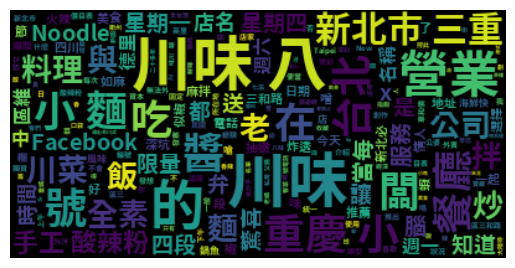

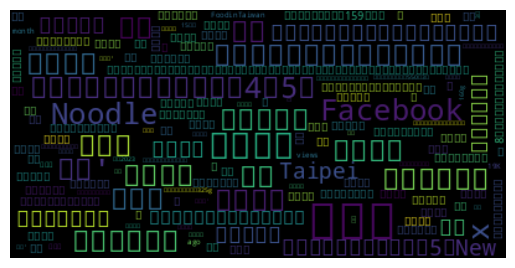

In [9]:
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as font
import jieba

# 設定字型的路徑
# myfont = font(fname="/data1/env/py310helperbot/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/TaipeiSansTCBeta-Bold.ttf")
# matplotlib.rc('font', family='sans',serif=['Taipei Sans TC Beta'])
# plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # 修改中文字體
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['axes.unicode_minus'] = False


text = """
台北川味八-重慶小麵/手工酸辣粉外送| 菜單和價目表 (川味八-重慶小麵/手工酸辣粉在台北的價目表與外賣服務. 川味八-重慶小麵/手工酸辣粉. 4.4 x (66) • 6437.1 英里. x 無法外送. 新北市三重區三和路四段5號New Taipei, ...)
38 Noodle - 限量弁當每星期一與星期四腦闆 ... - Facebook (限量弁當每星期一與星期四腦闆固定創作發想日不會提前知道是什麼便當但每次推出都是驚喜讓我知道你喜歡這樣的驚喜嗎 🌶️店名：川味八公婆🌶️ ⌚️營業時間：週一～週六 ...)
川味八- 店家介紹 (統一編號. 92788743 · 公司狀況. 營業中 · 公司名稱. 川味八 · 公司類型. 獨資 · 資本總額. 100000 · 所在地. 新北市三重區維德里三和路4段5號 · 使用發票. 否 · 設立日期. 民國 ...)
38 Noodle - 今天情人節火辣在一起如麻似椒 ... - Facebook (今天情人節火辣在一起如麻似椒❤️❤️❤️ 🌶️店名：川味八🌶️ ⌚️營業時間：週一～週六 上午：11:00-14:00 下午：17:00-21:00 電話：0976529478 地址：新北市三重區三 ...)
川味不一般，全台灣只有這裡才吃得的衢州鮮辣| 旅遊經 (... 八味」之說，「七滋」指甜、酸、麻、辣、苦、香 ... 在大陸待了二十多年，川味的香辣早已經深深刻劃 ... 新北市深坑區深坑街159號電話：（02）2664-4879)
川菜控此篇必收藏！8間饕客們的台北寶藏口袋名單，讓人 ... (台北川菜餐廳推薦 · 真川味老舖 · 黔園川菜餐廳 · 四川吳炒手 · 皇城老媽川味私房料理 · 駱師父醬味川客菜 · 成都滿庭芳川式料理 · 四川蜀渝小吃.)
川味椒麻拌醬(全素) - 素食港式飲茶- 養心茶樓 (全素醬料，拌飯、拌麵、沾、炒、拌、烤百搭天王○ 川味椒麻拌醬：香麻上癮、不燥開胃、溫辣百搭○ 料理紅油抄手、麻辣鍋，襯出好滋味. 常溫商品【全素辣醬新選擇】)
川味八 (狀態, 營業中 ; 營業地址, 新北市三重區維德里三和路4段5號 ; 統編, 92788743 ; 營業名稱, 川味八 ; 資本額, 100,000.)
【新北必吃美食】炸透抽嫩/味噌蝦/海鮮快炒/爆漿飯糰/川味嗆鍋魚 ... (【新北必吃美食】炸透抽嫩/味噌蝦/海鮮快炒/爆漿飯糰/川味嗆鍋魚/無刺白帶魚卷/人氣包子店/小卷米粉@FoodinTaiwan. 19K views · 1 month ago #白帶魚 ...)
(即期品)康寶川味八香辣椒醬325g/瓶(效期2023/06/05) (台北市忠孝東路四段550號3樓. 保存期限, 15個月. 製造日期／有效 ... 丸美屋蠟筆小新甘口風味咖哩醬[附貼紙] 160g. $69 ... 川辣/泡菜(3入) 款式可選【小三美日】空運禁送 ...)
顧客評價： 麵食及酸辣粉都推薦半乾湯吃法～ 店面雖然很小卻別有一番風味～ 牛肉麵還可以免費加大 老闆，老闆娘很用心的服務 會再來吃！ 樓下開了好吃的重慶小麵啦～下次也想來試試紅油水餃 小菜選擇超多好讚👍👍

類似的店： ['中國菜'] ['餐廳'] ['燒烤'] ['熟食店'] ['餐廳']

電話號碼： 0976 529 478
"""
# Generate a word cloud image
wc_generator = WordCloud(font_path="/data1/env/py310helperbot/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/TaipeiSansTCBeta-Bold.ttf")
wordcloud = wc_generator.generate( " ".join(jieba.cut(text)))
fig, ax = plt.subplots()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [15]:
from PIL import Image
isinstance(wordcloud.to_image(), Image.Image)


True

### B2B 客戶名單 ###

In [4]:

# data = pd.read_csv("/home/kota/nlp/data/leads/政府開放資料-稅籍編號-BGMOPEN1.csv")

    
file_path = "data/餐廳類型分類.xlsx - 測試清單.csv"
data = get_leads( file_path)
data.head()

In [69]:
construction_category = list(set([ 
    x for x in data['名稱'].unique() if not pd.isna(x) and ('工程' in x or '營建' in x )] + \
    [ x for x in data['名稱2'].unique() if not pd.isna(x) and ('工程' in x or '營建' in x )] + \
    [ x for x in data['名稱3'].unique() if not pd.isna(x) and ('工程' in x or '營建' in x )
]))
leads = data[ 
    data['營業地址'].str.contains('高雄') & \
    (data['名稱'].isin(construction_category) | data['名稱2'].isin(construction_category) | data['名稱3'].isin(construction_category)) ]
large_leads = leads[leads['資本額']>=50000000]
large_leads = large_leads.sort_values(by='資本額', ascending=False)
large_leads.to_csv("/home/kota/nlp/data/leads/large_construction_leads.csv", index=False)

In [76]:
large_leads['名稱'].value_counts().head(10)

未分類其他土木工程    89
住宅營建         27
其他建築工程       23
管道工程         14
市區下水道土木工程    14
電路工程         14
水電工程         14
室內裝潢工程       13
不動產投資開發      11
未分類其他專門營造    11
Name: 名稱, dtype: int64